# Vidsualization Loss Curve

📌 可用的 scalar tags:
['Loss/Train', 'Loss/Val']


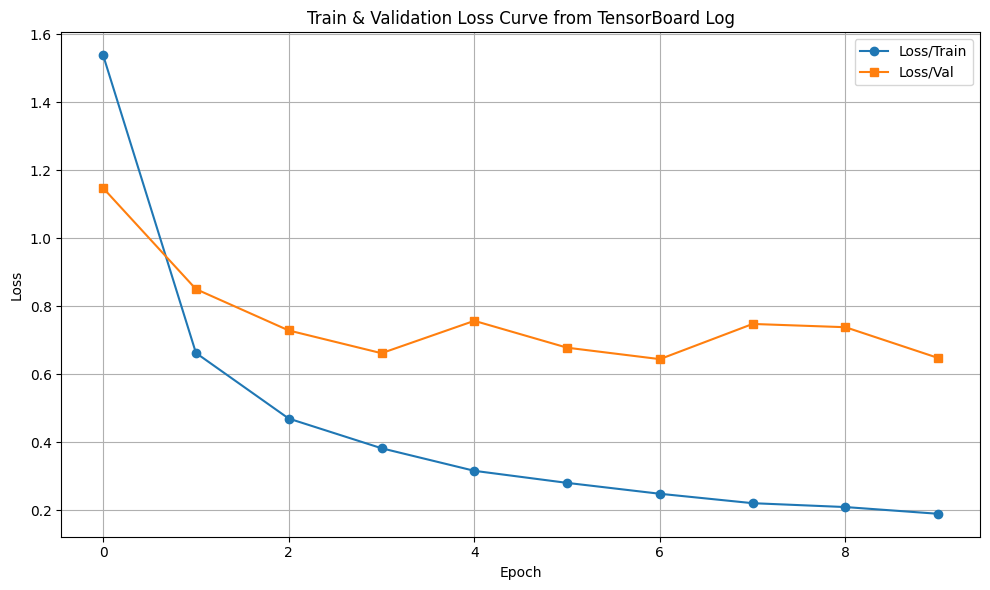

In [1]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 配置：设置 TensorBoard 日志路径
exp_name = 'exp_lstm_add_attn_mel_hidenLayer128_multihead_cnndataAug'
exp_root = 'E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments'
log_dir = f"{exp_root}/{exp_name}/logs"

# 加载 TensorBoard 事件文件
event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out.tfevents")]
if not event_files:
    raise FileNotFoundError("未找到 TensorBoard 日志文件，请检查路径是否正确。")

event_path = os.path.join(log_dir, event_files[0])
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# 打印所有可用 scalar tags
available_tags = event_acc.Tags()["scalars"]
print("📌 可用的 scalar tags:")
print(available_tags)

# 自动选择最接近的 tag（或手动改成实际 tag）
train_tag = next((tag for tag in available_tags if "Train" in tag), None)
val_tag = next((tag for tag in available_tags if "Val" in tag or "Validation" in tag), None)

if not train_tag or not val_tag:
    raise KeyError("未找到包含 Train 或 Validation 的 scalar tag，请检查日志记录的名称。")

train_events = event_acc.Scalars(train_tag)
val_events = event_acc.Scalars(val_tag)

# 提取 step 和 value
train_steps = [e.step for e in train_events]
train_values = [e.value for e in train_events]

val_steps = [e.step for e in val_events]
val_values = [e.value for e in val_events]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_values, label=f"{train_tag}", marker="o")
plt.plot(val_steps, val_values, label=f"{val_tag}", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss Curve from TensorBoard Log")
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation LSTM

📊 LSTM 数据集构建完成：共 9900 条样本，类别数：33


C:\Users\40920\AppData\Local\Temp\ipykernel_165328\3204994158.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CONFIG["model_path"], map

✅ 分类报告已保存至: E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/exp_lstm_add_attn_mel_hidenLayer128_multihead_cnndataAug/eval_results_best_model\classification_report.txt


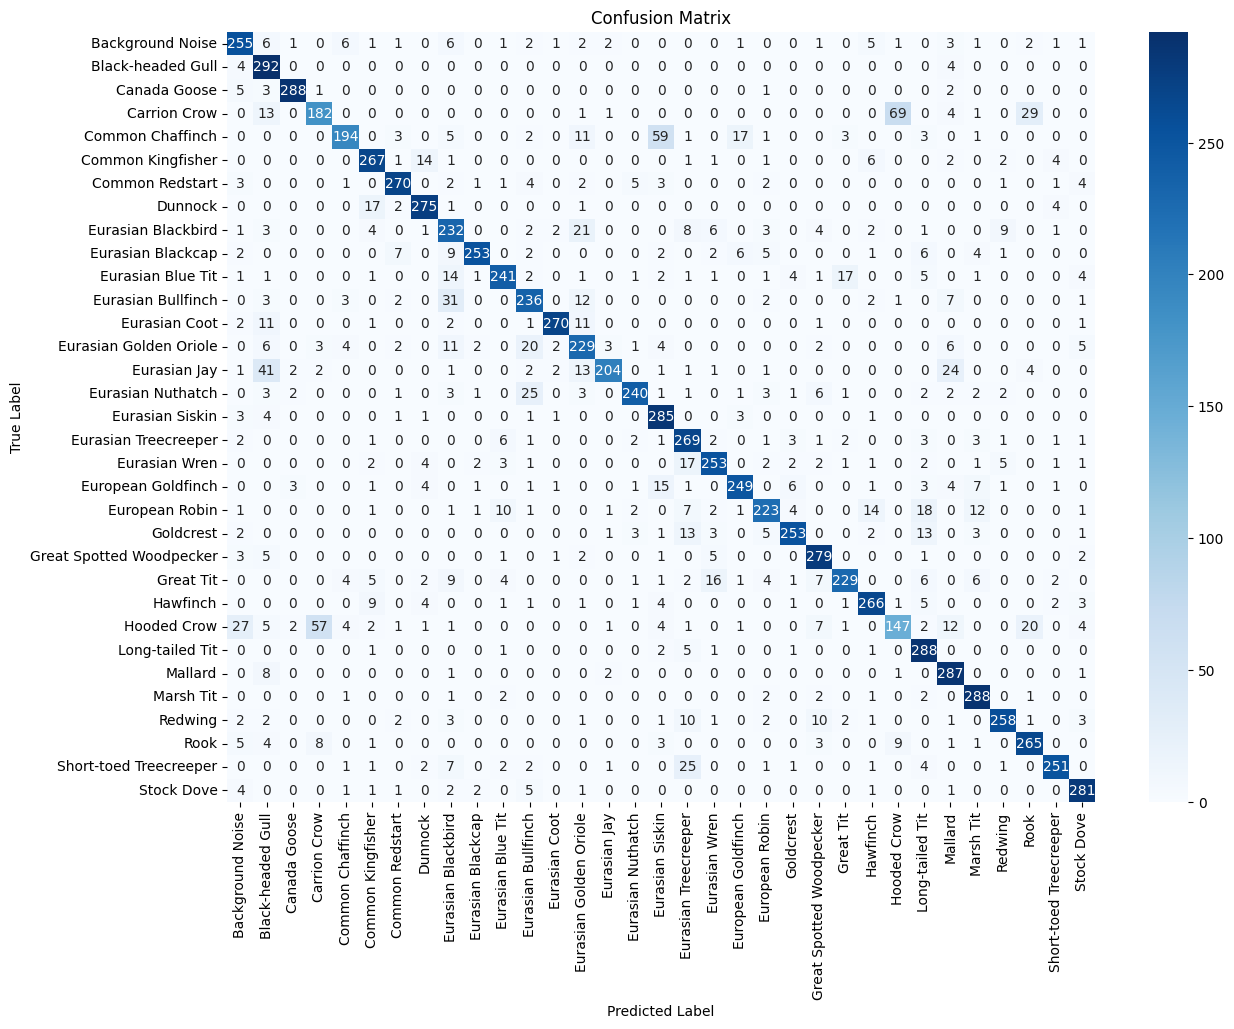

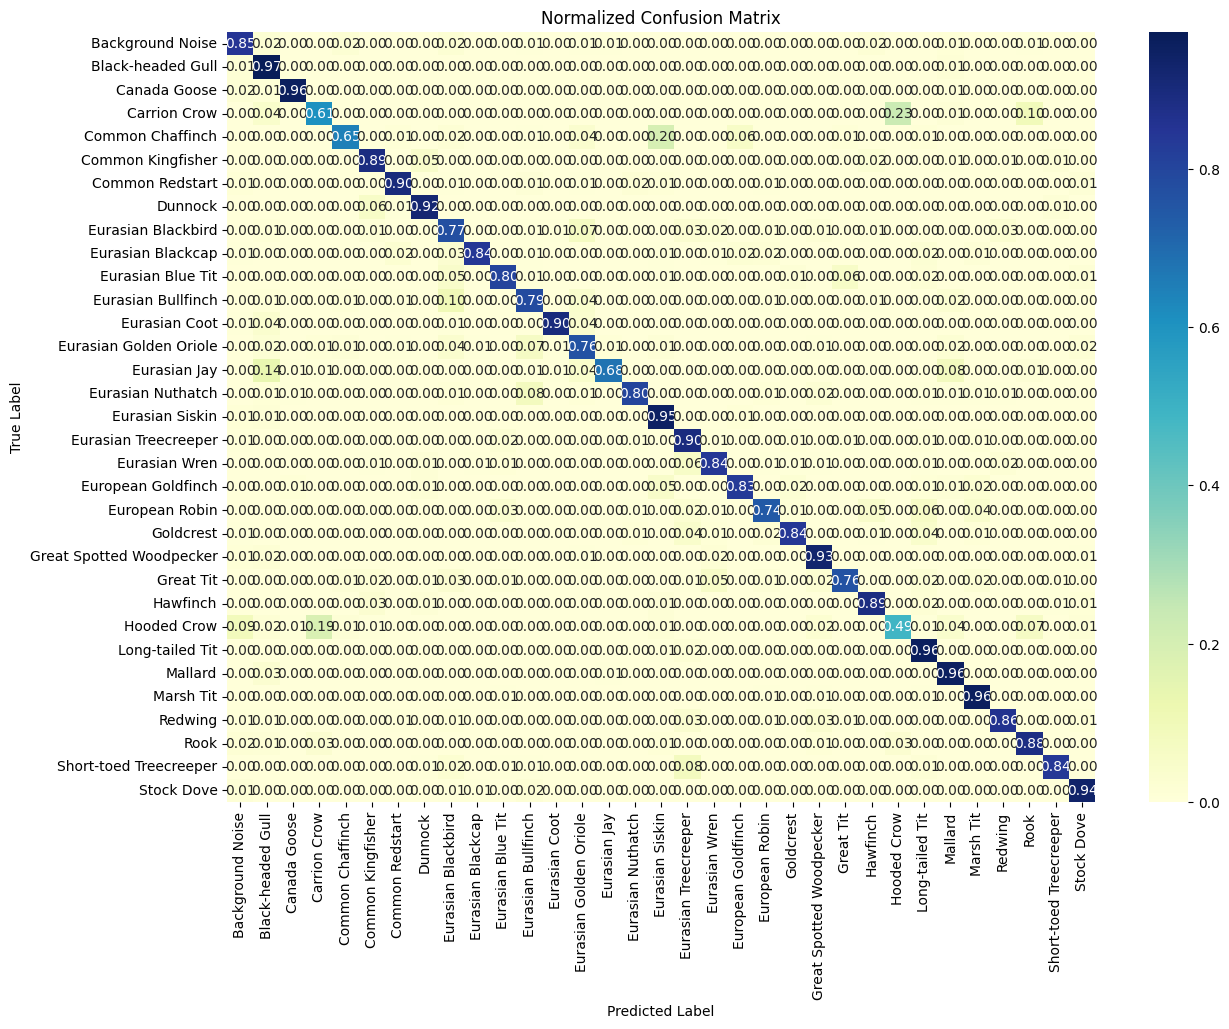

C:\Users\40920\AppData\Local\Temp\ipykernel_165328\3204994158.py:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', CONFIG["num_classes"])


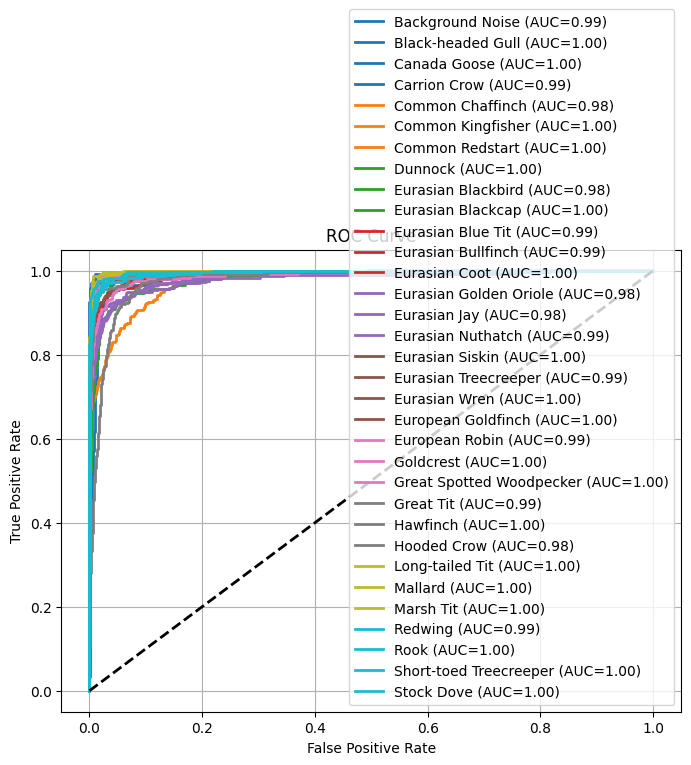

📊 推理结果已保存 ✅


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from model.model import BirdSoundLSTM, BirdSoundCNNLSTM_Attention, BirdSoundCNNLSTM_MultiHeadAttn, BirdSoundLSTM_Attn, BirdSoundGRU
from data.dataset import get_loader
from data.utils_bird_mapping import get_class_labels, build_index_to_label
from bird_name_mapping import bird_name_mapping  # 替换为你的实际映射

# ⚙️ 配置
exp_name = 'exp_lstm_add_attn_mel_hidenLayer256'
model_name = 'best_model'
root_data_path = 'E:/AMR/DA/Projekt/data/data_list/0408'
CONFIG = {
    "valid_csv": f"{root_data_path}/valid_list_high_quality.csv",
    "model_path": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/{exp_name}/models/{model_name}.pth",
    "num_classes": len(set(bird_name_mapping.values())),
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "output_dir": f"E:/AMR/DA/Projekt/bird_cls_cnn/projekt_LSTM/experiments/{exp_name}/eval_results_{model_name}",
    "hidden_dim": 128,
    "num_layers": 2,
    "bidirectional": True,
}
os.makedirs(CONFIG["output_dir"], exist_ok=True)

# 📋 标签映射
class_labels = get_class_labels(bird_name_mapping, merge_names=True)
index_to_bird = build_index_to_label(bird_name_mapping, merge_names=True)

# 📦 数据加载器
test_loader = get_loader(
    csv_path=CONFIG["valid_csv"],
    bird_name_mapping=bird_name_mapping,
    batch_size=CONFIG["batch_size"],
    num_workers=4,
    augment=False,
    use_weighted_sampler=False,
    max_samples=2000
)

# ✅ 加载模型
# model = BirdSoundLSTM(
#     input_dim=256,
#     hidden_dim=128,
#     num_layers=2,
#     num_classes=CONFIG["num_classes"],
#     bidirectional=True
# ).to(CONFIG["device"])

# model = BirdSoundLSTM_Attn(
#     input_dim=256,
#     hidden_dim=CONFIG["hidden_dim"],
#     num_layers=CONFIG["num_layers"],
#     num_classes=CONFIG["num_classes"],
#     bidirectional=CONFIG["bidirectional"]
# ).to(CONFIG["device"])

# model = BirdSoundCNNLSTM_Attention(
#     input_dim=256,  # 每帧特征维度，如果你前面 CNN 有输出 shape，记得同步
#     hidden_dim=128,
#     num_layers=2,
#     num_classes=CONFIG["num_classes"],
#     bidirectional=True,
# ).to(CONFIG["device"])

model = BirdSoundCNNLSTM_MultiHeadAttn(
    input_dim=256,
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_classes=CONFIG["num_classes"],
    bidirectional=CONFIG["bidirectional"],
    num_heads=4 # 可调参数
).to(CONFIG["device"])

model.load_state_dict(torch.load(CONFIG["model_path"], map_location=CONFIG["device"]))
model.eval()

# 🔎 推理函数
def evaluate(model, loader, device):
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# ✅ 执行推理
true_labels, pred_labels, prob_scores = evaluate(model, test_loader, CONFIG["device"])

# 📈 准确率和报告
accuracy = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=class_labels, digits=4)

report_path = os.path.join(CONFIG["output_dir"], "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"✅ 分类报告已保存至: {report_path}")

# 🔵 混淆矩阵
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix.png"))
plt.show()

# 🔷 归一化混淆矩阵
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.savefig(os.path.join(CONFIG["output_dir"], "confusion_matrix_normalized.png"))
plt.show()

# 🔺 ROC 曲线
true_bin = label_binarize(true_labels, classes=np.arange(CONFIG["num_classes"]))
colors = plt.cm.get_cmap('tab10', CONFIG["num_classes"])
plt.figure(figsize=(8, 6))
for i in range(CONFIG["num_classes"]):
    fpr, tpr, _ = roc_curve(true_bin[:, i], prob_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC={roc_auc:.2f})", color=colors(i))
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(CONFIG["output_dir"], "roc_curve.png"))
plt.show()

# 📑 结果保存
df = pd.DataFrame({
    "True Label": [class_labels[i] for i in true_labels],
    "Predicted Label": [class_labels[i] for i in pred_labels]
})
for i, name in enumerate(class_labels):
    df[f"Confidence_{name}"] = prob_scores[:, i]

df.to_csv(os.path.join(CONFIG["output_dir"], "evaluation_results.csv"), index=False, encoding="utf-8-sig")
print("📊 推理结果已保存 ✅")
